<a href="https://colab.research.google.com/github/Ruben-Salumu/Ruben-Salumu/blob/main/pneumonia_v00.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import numpy as np
import PIL
import matplotlib.pyplot as plt

In [2]:
import pathlib
from huggingface_hub import hf_hub_download
#hf_hub_download outputs a str
path_to_data = hf_hub_download(repo_id="trpakov/chest-xray-classification", local_dir = "/root/.keras/datasets/", filename="data/train.zip", repo_type="dataset")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


train.zip:   0%|          | 0.00/409M [00:00<?, ?B/s]

In [4]:
!pip install zipfile
import zipfile

# Rest of the user code here.

ERROR: Could not find a version that satisfies the requirement zipfile (from versions: none)
ERROR: No matching distribution found for zipfile


In [5]:
with zipfile.ZipFile(path_to_data, 'r') as training_archive:
  training_archive.extractall("/root/.keras/datasets/data/")

In [8]:
!pip install fnmatch
import fnmatch
import os

dir_path = r'/root/.keras/datasets/data/PNEUMONIA'
count_pneumonia = len(fnmatch.filter(os.listdir(dir_path), '*.jpg'))
print('Pneumonia images:', count_pneumonia)

dir_path = r'/root/.keras/datasets/data/NORMAL'
count_normal = len(fnmatch.filter(os.listdir(dir_path), '*.jpg'))
print('Normal images:', count_normal)


ERROR: Could not find a version that satisfies the requirement fnmatch (from versions: none)
ERROR: No matching distribution found for fnmatch
Pneumonia images: 8918
Normal images: 3312


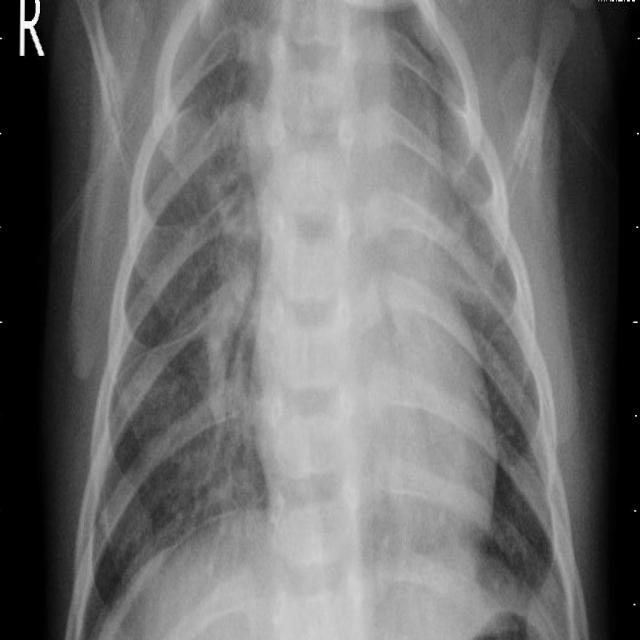

In [9]:
path_to_dataset = '/root/.keras/datasets/data/'
path_to_stuff = pathlib.Path('/root/.keras/datasets/data/').with_suffix('')
pneumonia = list(path_to_stuff.glob('PNEUMONIA/*')) #An array of paths to each x-ray image in the PNEUMONIA folder
PIL.Image.open(str(pneumonia[49]))

In [10]:
batch_size = 30
xray_height = 150
xray_width = 150

In [11]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  path_to_dataset,
  validation_split = 0.3,
  subset = "training",
  seed = 100, #Determines initial values of weights
  image_size = (xray_height, xray_width),
  batch_size = batch_size)

Found 12230 files belonging to 2 classes.
Using 8561 files for training.


In [12]:
valid_ds = tf.keras.utils.image_dataset_from_directory(
  path_to_dataset,
  validation_split = 0.3,
  subset = "validation",
  seed = 100, #Determines initial values of weights
  image_size = (xray_height, xray_width),
  batch_size = batch_size)

Found 12230 files belonging to 2 classes.
Using 3669 files for validation.


In [13]:
categories = train_ds.class_names
print(categories)

['NORMAL', 'PNEUMONIA']


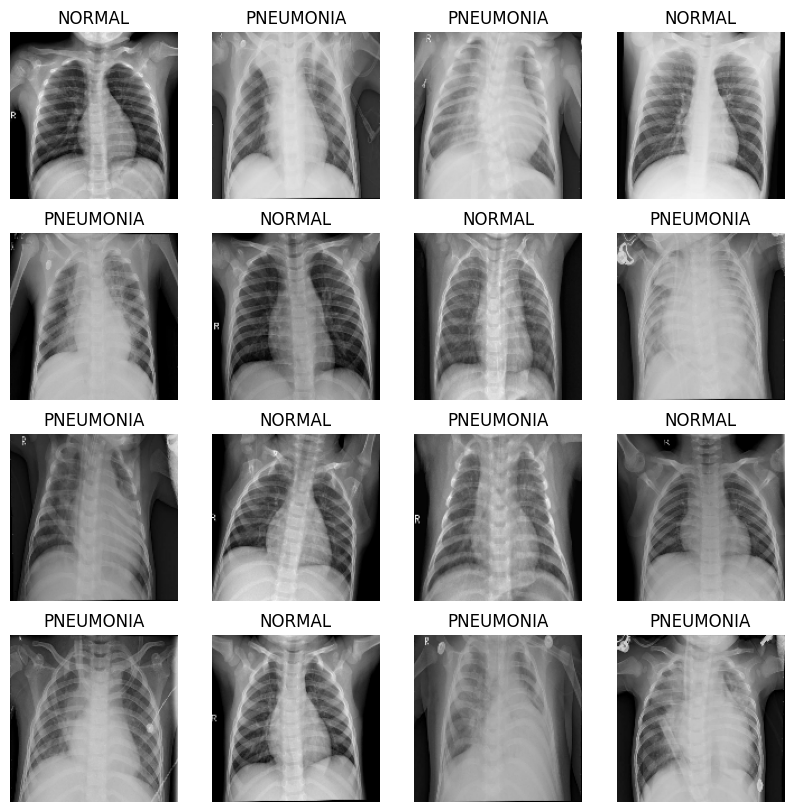

In [14]:
plt.figure(figsize = (10, 10))
for images, labels in train_ds.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(categories[labels[i]])
    plt.axis("off")

In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE) #Caching
valid_ds = valid_ds.cache().prefetch(buffer_size = AUTOTUNE) #Prefetchinga

In [27]:
num_classes = len(categories)

model = Sequential([

  layers.Conv2D(16, 3, padding = 'same', activation = 'relu'), #3 input channels, 16 output channels. 3x3 convolution kernel.
  layers.MaxPooling2D(), #Downsample 150x150 -> 75x75
  layers.Conv2D(32, 3, padding = 'same', activation = 'relu'), #16 input channels, 32 output channels. 3x3 convolution kernel.
  layers.MaxPooling2D(), #Downsample, 75x75 -> 37x37
  layers.Conv2D(64, 3, padding = 'same', activation = 'relu'), #32 input channels, 64 output channels. 3x3 convolution kernel.
  layers.MaxPooling2D(), #Downsample, 37x37 -> 18x18
  layers.Flatten(), #1 dimensional tensor, 18*18*64 = 20736 channels/parameters
  layers.Dense(128, activation = 'relu'), #1 dimensional tensor, 128 output channels. 128*(20736+1) = 2654336 parameters
  layers.Dense(num_classes) #1 dimensional tensor, 2 output channel (one for each category, NORMAL and PNEUMONIA).
])

In [28]:
model.compile(optimizer = 'adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy'])

In [29]:
epochs = 5
history = model.fit(
  train_ds,
  validation_data = valid_ds,
  epochs = epochs
)

Epoch 1/5
286/286 [==============================] - 233s 752ms/step - loss: 3.4885 - accuracy: 0.9059 - val_loss: 0.1550 - val_accuracy: 0.9436
Epoch 2/5
286/286 [==============================] - 203s 711ms/step - loss: 0.1464 - accuracy: 0.9479 - val_loss: 0.1957 - val_accuracy: 0.9270
Epoch 3/5
286/286 [==============================] - 223s 780ms/step - loss: 0.0956 - accuracy: 0.9638 - val_loss: 0.1062 - val_accuracy: 0.9613
Epoch 4/5
286/286 [==============================] - 222s 777ms/step - loss: 0.0634 - accuracy: 0.9777 - val_loss: 0.0918 - val_accuracy: 0.9648
Epoch 5/5
286/286 [==============================] - 223s 781ms/step - loss: 0.0554 - accuracy: 0.9791 - val_loss: 0.1328 - val_accuracy: 0.9545


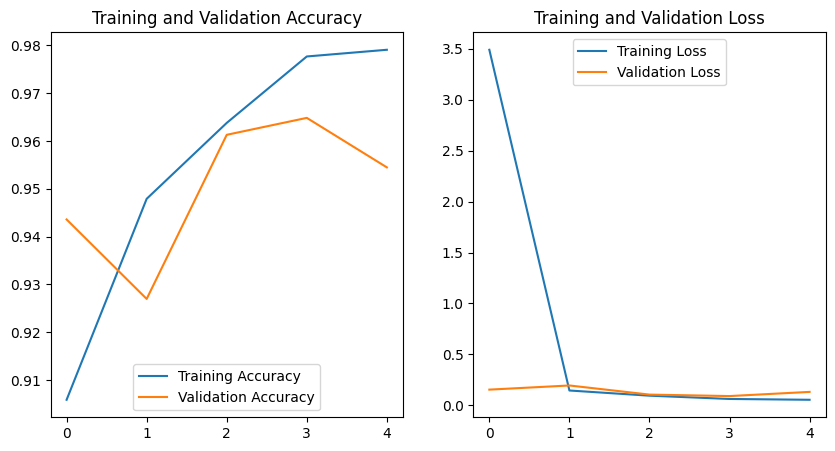

In [30]:
accuracy = history.history['accuracy']
valid_accuracy = history.history['val_accuracy']

loss = history.history['loss']
valid_loss = history.history['val_loss']

no_of_epochs = range(epochs)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(no_of_epochs, accuracy, label='Training Accuracy')
plt.plot(no_of_epochs, valid_accuracy, label='Validation Accuracy')
plt.legend(loc='lower center')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(no_of_epochs, loss, label='Training Loss')
plt.plot(no_of_epochs, valid_loss, label='Validation Loss')
plt.legend(loc='upper center')
plt.title('Training and Validation Loss')
plt.show()

In [31]:
model.save('pneumonia_v00.keras')